In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import torch
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm, trange
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.datasets import ImageFolder


from predictors.alexnet import Alexnet
from predictors.half_alexnet import HalfAlexnet

from datasets import CIFAR10

%matplotlib inline

In [4]:
LR = 0.001
EPOCHS = 200
BATCH_SIZE = 32
CONFIDENCE_TH = 0.8

DATASET_PATH = '.'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
# Teacher
teacher_model = Alexnet(name=None, n_outputs=10)

ckpt_path = 'checkpoints/teacher_alexnet_for_cifar10_state_dict'
teacher_model.load_state_dict(torch.load(ckpt_path, map_location=device))
teacher_model.eval()
teacher_model.to(device)

Alexnet(
  (conv1): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (lrn): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
  (pad): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm2): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm5): BatchNorm2d(128, eps=0.001, m

In [6]:
# Define dataset
label_mapper = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}
label_mapper_inv = {v:k for k,v in label_mapper.items()}

# Get images paths and labels
images = []
labels = []
folders_path = os.path.join(DATASET_PATH,'images_generated')
for folder in os.listdir(folders_path):
    if 'imagenet' in folder:
      continue
    class_path = os.path.join(folders_path,folder)
    images_names = os.listdir(class_path)
    
    for image_name in images_names:
        images.append(os.path.join(class_path,image_name))
        labels.append(label_mapper[folder])

In [7]:
# Define dataset class
class ProxyDataset(Dataset):
    def __init__(self, images, labels, transform=None, return_path=False, soft_label=None):
        self.images = images
        self.labels = labels
        self.soft_label = soft_label
        
        self.transform = transform
        
        self.return_path = return_path

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = read_image(self.images[idx])
        image = image / 255.0
        
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
            
        if self.return_path:
            return image, label, self.images[idx]
        
        return image, label, self.soft_label[idx]
    
# Filter out images with low confidence score
proxy_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

proxy_dataset = ProxyDataset(images, labels, proxy_transforms, True)
proxy_dataloader  = DataLoader(proxy_dataset,  batch_size=BATCH_SIZE)

filtered_images = []
filtered_labels = []
filtered_soft_labels = []

with torch.no_grad():
    for img,label,path in tqdm(proxy_dataloader):
        img = img.to(device=device)
        label = label.to(device=device)

        logits = teacher_model(img)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)

        filtered_images.extend(list(path))
        filtered_labels.extend(y_hat.tolist())
        filtered_soft_labels.extend(pred)
        
# Display results of filtering
print(f'A total of {len(filtered_images)} remained out of {len(proxy_dataset)}')
print()
counter_per_class = {v:0 for k,v in label_mapper.items()}
for label in filtered_labels:
    counter_per_class[label] += 1
for clasa in counter_per_class:
    print(f'Class {clasa}({label_mapper_inv[clasa]}) has {counter_per_class[clasa]} entries')

  0%|          | 0/1600 [00:00<?, ?it/s]

A total of 51200 remained out of 51200

Class 0(airplane) has 6384 entries
Class 1(automobile) has 5145 entries
Class 2(bird) has 4795 entries
Class 3(cat) has 5331 entries
Class 4(deer) has 5571 entries
Class 5(dog) has 4286 entries
Class 6(frog) has 4553 entries
Class 7(horse) has 5025 entries
Class 8(ship) has 5178 entries
Class 9(truck) has 4932 entries


In [8]:
# Define the student model
student_model = HalfAlexnet(name=None, n_outputs=10)

path_to_save = 'pretrained_student.pt'
student_model.load_state_dict(torch.load(path_to_save))
student_model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=LR)

# Define loss function
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

In [9]:
""" Old block: used with percengtages
PERCENTAGE_TO_USE = 0.8
print(f'Examples used: {len(filtered_images)*PERCENTAGE_TO_USE}')

filtered_images_subset, _, filtered_labels_subset, _, filtered_soft_labels_subset, _ = \
    train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=PERCENTAGE_TO_USE, stratify=filtered_labels)

train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
      train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=0.8, stratify=filtered_labels)
valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
    train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)
"""

try:
  # raise
  # Do a stratified split of the data
  NO_IMGS_TO_USE = 32768
  
  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
      train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels)  

  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
      train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=0.8, stratify=filtered_labels_subset)
  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)
except:
  # For small datasets 
  print('Small dataset')
  NO_IMGS_TO_USE = 30
  NO_TRAIN_IMGS = 10

  """ DEV - train_test_split fails, need to manually introduce 1 sample
  """
  for i in range(len(filtered_labels)-1,-1,-1):
    if filtered_labels[i] == 5:
      img_dev = filtered_images[i]
      soft_label_dev = filtered_soft_labels[i]
      break

  filtered_images_subset, filtered_images_unused, filtered_labels_subset, filtered_labels_unused, filtered_soft_labels_subset, filtered_soft_labels_unused = \
    train_test_split(filtered_images, filtered_labels, filtered_soft_labels, train_size=NO_IMGS_TO_USE, stratify=filtered_labels)  
  train_images, validation_images, train_labels, validation_labels, train_soft_labels, validation_soft_labels = \
    train_test_split(filtered_images_subset, filtered_labels_subset, filtered_soft_labels_subset, train_size=NO_TRAIN_IMGS, stratify=filtered_labels_subset)
  
  """ DEV - interchange an image
  """
  for i in range(len(validation_images)):
    if validation_labels[i] == 0:
      validation_images[i] = img_dev
      validation_labels[i] = 5
      validation_soft_labels[i] = soft_label_dev
      break

  valid_images, test_images, valid_labels, test_labels, valid_soft_labels, test_soft_labels = \
      train_test_split(validation_images, validation_labels, validation_soft_labels, test_size=0.5, stratify=validation_labels)

In [10]:
# Define the transformations
train_transforms = T.Compose([
    T.Resize((32,32)),
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize((0.5,), (0.5,))
])
valid_transforms = T.Compose([
    T.Resize((32,32)),
    T.Normalize((0.5,), (0.5,))
])

# Define the datasets
proxy_train_dataset = ProxyDataset(train_images, train_labels, train_transforms, False, train_soft_labels)
proxy_valid_dataset = ProxyDataset(valid_images, valid_labels, valid_transforms, False, valid_soft_labels)
proxy_test_dataset  = ProxyDataset(test_images,  test_labels,  valid_transforms, False, test_soft_labels)

# Define the dataloaders
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(proxy_valid_dataset, batch_size=BATCH_SIZE)
test_dataloader  = DataLoader(proxy_test_dataset,  batch_size=BATCH_SIZE)

In [11]:
# Define true dataset
true_dataset = CIFAR10(input_size = 32)

validate_on_trueds = True
if validate_on_trueds:
    true_valid_ds = true_dataset.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Class for early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, validation_loss):
        if self.best_score is None:
          self.best_score = validation_loss
        elif validation_loss - self.best_score < self.min_delta:
          self.best_score = validation_loss
        else:
          self.counter +=1
          if self.counter >= self.tolerance:  
              self.early_stop = True

In [13]:
early_stopping = EarlyStopping(tolerance=20, min_delta=0.001)
# early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)

# Training the student
for epoch in range(EPOCHS):
    # Define progress bar
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    
    # Training loop
    student_model.train()
    training_loss_epoch = []
    for batch_idx, (x,y,soft_y) in loop:
        optimizer.zero_grad()
        
        x = x.to(device=device)
        y = y.to(device=device)
        soft_y = soft_y.to(device=device)
        
        # Forward pass
        logits = student_model(x)
        # Backward pass
        loss = criterion(input=logits, target=soft_y)
        training_loss_epoch.append(loss.item())
        # Prob trb inlocuit criterionul, sa adaugi soft-labels
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update progress bar
        loop.set_description(f'Epoch {epoch+1}/{EPOCHS}')
        loop.set_postfix(training_loss=loss.item())
    
    # Validation loop on proxy validation dataset
    student_model.eval()
    validation_loss_epoch = []  
    acc = 0
    with torch.no_grad():
        for x,y,_ in valid_dataloader:
            x = x.to(device=device)
            y = y.to(device=device)
        
            logits = student_model(x)
            pred = softmax(logits, dim=1)
            
            confidence,y_hat = torch.max(pred, dim=1)
            
            loss = criterion(input=logits, target=y)
            validation_loss_epoch.append(loss.item())
            
            acc += torch.sum(y_hat==y).item()
        
    loop.write(f'validation_loss on proxy = {sum(validation_loss_epoch)/len(validation_loss_epoch):.4f}')
    loop.write(f'validation_accuracy on proxy = {100*acc/len(proxy_valid_dataset):.2f}%')

    if validate_on_trueds:
        # Validation loop on proxy validation dataset
        student_model.eval()
        with torch.no_grad():
            val_loss = []
            acc = 0
            for x,y in true_valid_ds:
                x = x.to(device=device)
                y = y.to(device=device)
            
                logits = student_model(x)
                pred = softmax(logits, dim=1)
                
                confidence,y_hat = torch.max(pred, dim=1)
                
                loss = criterion(input=logits, target=y)
                val_loss.append(loss.item())
                
                acc += torch.sum(y_hat==y).item()
            
        loop.write(f'validation_loss on true ds = {sum(val_loss)/len(val_loss):.4f}')
        loop.write(f'validation_accuracy on true ds = {100*acc/len(true_dataset.test_dataset):.2f}%')

    early_stopping(sum(validation_loss_epoch)/len(validation_loss_epoch))
    if early_stopping.early_stop:
      print(f"We are at epoch {epoch}")
      break

  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5524
validation_accuracy on proxy = 83.86%
validation_loss on true ds = 1.3531
validation_accuracy on true ds = 53.55%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.5150
validation_accuracy on proxy = 85.38%
validation_loss on true ds = 1.2756
validation_accuracy on true ds = 56.74%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4979
validation_accuracy on proxy = 85.29%
validation_loss on true ds = 1.2332
validation_accuracy on true ds = 58.40%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4923
validation_accuracy on proxy = 84.96%
validation_loss on true ds = 1.2451
validation_accuracy on true ds = 57.68%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4822
validation_accuracy on proxy = 86.05%
validation_loss on true ds = 1.1058
validation_accuracy on true ds = 61.28%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4808
validation_accuracy on proxy = 85.57%
validation_loss on true ds = 1.0476
validation_accuracy on true ds = 63.39%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4679
validation_accuracy on proxy = 86.21%
validation_loss on true ds = 1.1433
validation_accuracy on true ds = 61.42%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4652
validation_accuracy on proxy = 85.63%
validation_loss on true ds = 1.0127
validation_accuracy on true ds = 64.63%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4763
validation_accuracy on proxy = 86.02%
validation_loss on true ds = 1.0968
validation_accuracy on true ds = 61.77%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4879
validation_accuracy on proxy = 85.66%
validation_loss on true ds = 1.0272
validation_accuracy on true ds = 64.84%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4748
validation_accuracy on proxy = 85.96%
validation_loss on true ds = 1.0290
validation_accuracy on true ds = 64.79%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4700
validation_accuracy on proxy = 85.99%
validation_loss on true ds = 1.0310
validation_accuracy on true ds = 64.41%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4610
validation_accuracy on proxy = 85.57%
validation_loss on true ds = 0.9835
validation_accuracy on true ds = 66.14%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4694
validation_accuracy on proxy = 85.57%
validation_loss on true ds = 1.0336
validation_accuracy on true ds = 64.51%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4508
validation_accuracy on proxy = 86.76%
validation_loss on true ds = 0.9802
validation_accuracy on true ds = 66.52%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4610
validation_accuracy on proxy = 85.93%
validation_loss on true ds = 1.0243
validation_accuracy on true ds = 65.05%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4661
validation_accuracy on proxy = 86.24%
validation_loss on true ds = 0.9784
validation_accuracy on true ds = 66.74%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4718
validation_accuracy on proxy = 86.63%
validation_loss on true ds = 1.0112
validation_accuracy on true ds = 65.55%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4516
validation_accuracy on proxy = 86.54%
validation_loss on true ds = 0.9103
validation_accuracy on true ds = 69.01%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4722
validation_accuracy on proxy = 86.73%
validation_loss on true ds = 0.9252
validation_accuracy on true ds = 68.65%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4546
validation_accuracy on proxy = 86.73%
validation_loss on true ds = 0.9437
validation_accuracy on true ds = 67.78%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4613
validation_accuracy on proxy = 86.21%
validation_loss on true ds = 0.9200
validation_accuracy on true ds = 68.45%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4590
validation_accuracy on proxy = 86.21%
validation_loss on true ds = 0.9400
validation_accuracy on true ds = 68.58%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4562
validation_accuracy on proxy = 86.48%
validation_loss on true ds = 0.9171
validation_accuracy on true ds = 68.79%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4580
validation_accuracy on proxy = 86.39%
validation_loss on true ds = 0.9436
validation_accuracy on true ds = 67.77%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4522
validation_accuracy on proxy = 86.08%
validation_loss on true ds = 0.9160
validation_accuracy on true ds = 68.54%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4523
validation_accuracy on proxy = 86.27%
validation_loss on true ds = 0.9326
validation_accuracy on true ds = 67.95%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4515
validation_accuracy on proxy = 86.51%
validation_loss on true ds = 0.9117
validation_accuracy on true ds = 68.42%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4526
validation_accuracy on proxy = 86.82%
validation_loss on true ds = 0.8839
validation_accuracy on true ds = 69.76%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4742
validation_accuracy on proxy = 86.15%
validation_loss on true ds = 0.9869
validation_accuracy on true ds = 66.67%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4643
validation_accuracy on proxy = 86.36%
validation_loss on true ds = 1.0331
validation_accuracy on true ds = 65.11%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4523
validation_accuracy on proxy = 86.42%
validation_loss on true ds = 0.9588
validation_accuracy on true ds = 67.45%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4581
validation_accuracy on proxy = 86.15%
validation_loss on true ds = 0.9465
validation_accuracy on true ds = 67.88%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4575
validation_accuracy on proxy = 86.48%
validation_loss on true ds = 0.9130
validation_accuracy on true ds = 68.96%


  0%|          | 0/820 [00:00<?, ?it/s]

validation_loss on proxy = 0.4648
validation_accuracy on proxy = 86.27%
validation_loss on true ds = 0.9655
validation_accuracy on true ds = 66.77%
We are at epoch 34


In [14]:
# Testing on CIFAR10 ground truth
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        y = y.to(device=device)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9655
test_accuracy = 66.77%

Class airplane: pred=510, actual=1000 => acc=51.00%, total_pred=606
Class automobile: pred=788, actual=1000 => acc=78.80%, total_pred=945
Class bird: pred=659, actual=1000 => acc=65.90%, total_pred=1186
Class cat: pred=710, actual=1000 => acc=71.00%, total_pred=1711
Class deer: pred=537, actual=1000 => acc=53.70%, total_pred=716
Class dog: pred=578, actual=1000 => acc=57.80%, total_pred=992
Class frog: pred=584, actual=1000 => acc=58.40%, total_pred=725
Class horse: pred=763, actual=1000 => acc=76.30%, total_pred=1114
Class ship: pred=782, actual=1000 => acc=78.20%, total_pred=1035
Class truck: pred=766, actual=1000 => acc=76.60%, total_pred=970


In [15]:
# Testing using labels predicted with teacher
true_dataloader = true_dataset.test_dataloader()
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
teacher_model.eval()
with torch.no_grad():
    test_loss = []
    acc = 0
    for x,y in true_dataloader:
        x = x.to(device=device)
        # y = y.to(device=device)

        teacher_pred = softmax(teacher_model(x), dim=1)
        _, y = torch.max(teacher_pred, dim=1)
    
        logits = student_model(x)
        pred = softmax(logits, dim=1)
        
        confidence,y_hat = torch.max(pred, dim=1)
        
        loss = criterion(input=logits, target=y)
        test_loss.append(loss.item())
        
        acc += torch.sum(y_hat==y)
        
        for i in range(len(y)):
            a = y[i].item()
            p = y_hat[i].item()
            
            
            acc_per_class[a][1] += 1
            acc_per_class[p][2] += 1
            if a == p:
                acc_per_class[a][0] += 1
        
    print('Student with true dataset:')
    print(f'test_loss = {sum(test_loss)/len(test_loss):.4f}')                  # 1.7439;  1.6199
    print(f'test_accuracy = {100*acc/len(true_dataset.test_dataset):.2f}%')    # 46.09%;  48.57%
    print()
    
for k,v in acc_per_class.items():
    print(f'Class {label_mapper_inv[k]}: pred={v[0]}, actual={v[1]} => acc={v[0]*100/v[1]:.2f}%, total_pred={v[2]}')

Student with true dataset:
test_loss = 0.9414
test_accuracy = 67.46%

Class airplane: pred=523, actual=1038 => acc=50.39%, total_pred=606
Class automobile: pred=800, actual=1002 => acc=79.84%, total_pred=945
Class bird: pred=667, actual=965 => acc=69.12%, total_pred=1186
Class cat: pred=690, actual=938 => acc=73.56%, total_pred=1711
Class deer: pred=562, actual=1108 => acc=50.72%, total_pred=716
Class dog: pred=581, actual=913 => acc=63.64%, total_pred=992
Class frog: pred=579, actual=996 => acc=58.13%, total_pred=725
Class horse: pred=790, actual=1063 => acc=74.32%, total_pred=1114
Class ship: pred=760, actual=939 => acc=80.94%, total_pred=1035
Class truck: pred=794, actual=1038 => acc=76.49%, total_pred=970


In [16]:
# Redefine training dataset and dataloader with no augmentation
proxy_train_dataset = ProxyDataset(train_images, train_labels, valid_transforms, False, train_soft_labels)
train_dataloader = DataLoader(proxy_train_dataset, batch_size=BATCH_SIZE, shuffle=True)


student_model.return_feature_domain = True

db_path = 'images_db'
images_path = os.path.join(db_path,'images')
labels_path = os.path.join(db_path,'labels')

images_db = []
labels_db = []

if not os.path.exists('images_db'):
  os.makedirs(db_path)
  os.makedirs(images_path)
  os.makedirs(labels_path)

  for i in range(10):
    os.makedirs(os.path.join(images_path,f'class{i}'))
    os.makedirs(os.path.join(labels_path,f'class{i}'))

# Create the database
student_model.eval()
with torch.no_grad():
  for dataloader in [train_dataloader, valid_dataloader, test_dataloader]:
    for x,y,soft_y in dataloader:
      x = x.to(device=device)

      _,latent_fm = student_model(x)

      for i in range(latent_fm.shape[0]):
        label = y[i].item()
        path_image = f'{images_path}/class{label}'
        path_label = f'{labels_path}/class{label}'
        
        idx = len(os.listdir(path_image))

        # torch.save(latent_fm[i].cpu(), f'{path_image}/t{idx}.pt')
        # torch.save(soft_y[i].cpu(), f'{path_label}/t{idx}.pt')

        images_db.append(latent_fm[i])
        labels_db.append(soft_y[i])

In [17]:
class DBDataset(Dataset):
  def __init__(self, images_db, labels_db):
    self.images_db = images_db
    self.labels_db = labels_db

  def __len__(self):
    return len(self.images_db)

  def __getitem__(self, idx):
    image = self.images_db[idx]
    label = self.labels_db[idx]

    return image, label

db_dataset = DBDataset(images_db=images_db, labels_db=labels_db)
db_dataloader = DataLoader(db_dataset, batch_size=128)

In [18]:
proxy_unused_dataset  = ProxyDataset(filtered_images_unused,  filtered_labels_unused,  valid_transforms, False, filtered_soft_labels_unused)

In [19]:
# estimations = []
# ground_truth = []

# with torch.no_grad():
#   for i in trange(len(proxy_unused_dataset)):
#     image, label, soft_label = proxy_unused_dataset[i]
#     image = image.to(device=device)

#     _,latent_fm = student_model(image.unsqueeze(dim=0))

#     norm_unkwn = torch.sqrt(torch.sum(torch.square(latent_fm), dim=(-1,-2,-3), keepdim=True))

#     # Calculate distances
#     distances = []
#     for img_db, softl_db in db_dataloader:
#       img_db = img_db.to(device=device)

#       norm_db = torch.sqrt(torch.sum(torch.square(img_db), dim=(-1,-2,-3), keepdim=True))

#       dot_prod = torch.tensordot(img_db, latent_fm, dims=[[-1,-2,-3],[-1,-2,-3]])
#       denominator = (norm_db * norm_unkwn).squeeze(dim=-1).squeeze(dim=-1)
#       cosine_similarities = (dot_prod / denominator).squeeze(dim=-1)

#       distances.extend(cosine_similarities.cpu().tolist())

#     # Get indices of smallest distances
#     distances = np.array(distances)
#     k = 3
#     smallest_indices = np.argpartition(distances, -k)[-k:]

#     smallest_d, smallest_slabels = [], []
#     for small_idx in smallest_indices:
#       img_db, softl_db = db_dataset[small_idx]
#       smallest_d.append(img_db.cpu().numpy())
#       smallest_slabels.append(softl_db.cpu().numpy())

#     smallest_d = np.array(smallest_d)
#     smallest_slabels = np.array(smallest_slabels)

#     estimated_soft_label = smallest_slabels.mean(0)

#     estimations.append(estimated_soft_label.argmax())
#     ground_truth.append(soft_label.argmax().cpu().item())
#     # print(f'Estimated hard label: {estimations[-1]}')
#     # print(f'Actual hard label: {ground_truth[-1]}')

#     if i % 1000 == 0 and i != 0:
#       # Display results
#       correct = (np.array(estimations) == np.array(ground_truth)).sum()
#       print(f'{correct} / {len(estimations)}')

# correct = (np.array(estimations) == np.array(ground_truth)).sum()
# print(f'Final score: {correct} / {len(estimations)}')

In [20]:
import matplotlib.pyplot as plt


def plot_db(X_embedded, labels_cpu):
  # scale and move the coordinates so they fit [0; 1] range
  def scale_to_01_range(x):
      # compute the distribution range
      value_range = (np.max(x) - np.min(x))
  
      # move the distribution so that it starts from zero
      # by extracting the minimal value from all its values
      starts_from_zero = x - np.min(x)
  
      # make the distribution fit [0; 1] by dividing by its range
      return starts_from_zero / value_range
  
  # extract x and y coordinates representing the positions of the images on T-SNE plot
  tx = X_embedded[:, 0]
  ty = X_embedded[:, 1]
  
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # initialize a matplotlib plot
  fig = plt.figure(figsize=(6, 6), dpi=144)
  ax = fig.add_subplot(111)
  
  # for every class, we'll add a scatter plot separately
  for label in range(10):
      # find the samples of the current class in the data
      indices = [i for i, l in enumerate(labels_cpu) if l == label]
  
      # extract the coordinates of the points of this class only
      current_tx = np.take(tx, indices)
      current_ty = np.take(ty, indices)
  
      # add a scatter plot with the corresponding color and label
      ax.scatter(current_tx, current_ty, label=label)
  
  # build a legend using the labels we set previously
  ax.legend(loc='best')
  
  # finally, show the plot
  plt.show()

/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vhondru/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


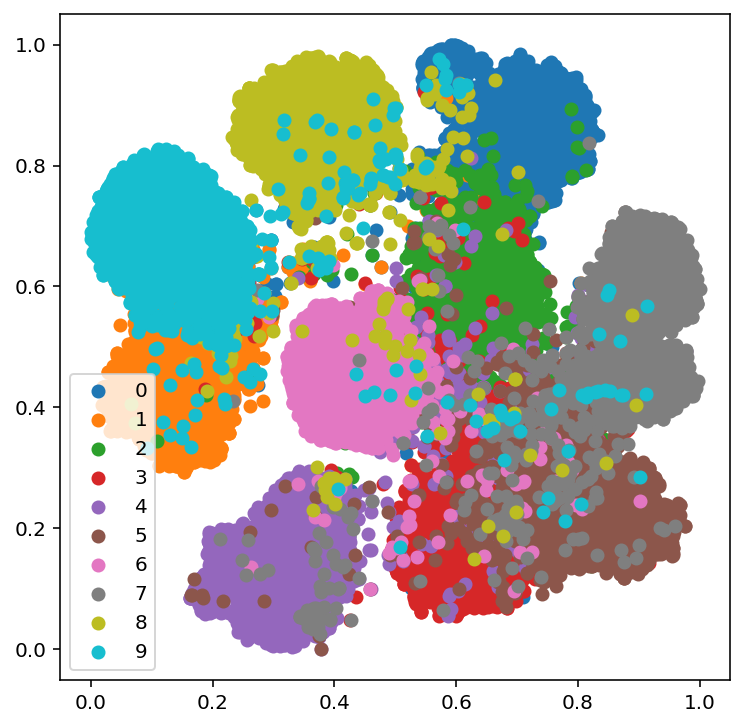

In [21]:
from sklearn.manifold import TSNE


tsne = TSNE()
images_cpu = [im.cpu().numpy().flatten() for im in images_db]
labels_cpu = [l.cpu().numpy().argmax() for l in labels_db]
X_embedded = tsne.fit_transform(np.array(images_cpu), np.array(labels_cpu))

plot_db(X_embedded, labels_cpu)

In [24]:
estimations = []
ground_truth = []

true_dataloader = torch.utils.data.DataLoader(
    true_dataset.test_dataset,
    batch_size = 1,
    num_workers = 2,
    drop_last = False
)
acc_per_class = {k:[0,0,0] for k,v in label_mapper_inv.items()}

student_model.eval()
with torch.no_grad():
  for i, (image, soft_label) in enumerate(tqdm(true_dataloader)):
    # image, label, soft_label = proxy_unused_dataset[i]
    image = image.to(device=device)
    soft_label = soft_label.to(device=device)

    _,latent_fm = student_model(image)
    # _,latent_fm = student_model(image.unsqueeze(dim=0))

    norm_unkwn = torch.sqrt(torch.sum(torch.square(latent_fm), dim=(-1,-2,-3), keepdim=True))

    # Calculate distances
    distances = []
    for img_db, softl_db in db_dataloader:
      img_db = img_db.to(device=device)

      norm_db = torch.sqrt(torch.sum(torch.square(img_db), dim=(-1,-2,-3), keepdim=True))

      dot_prod = torch.tensordot(img_db, latent_fm, dims=[[-1,-2,-3],[-1,-2,-3]])
      denominator = (norm_db * norm_unkwn).squeeze(dim=-1).squeeze(dim=-1)
      cosine_similarities = (dot_prod / denominator).squeeze(dim=-1)

      distances.extend(cosine_similarities.cpu().tolist())

    # Get indices of smallest distances
    distances = np.array(distances)
    k = 3
    smallest_indices = np.argpartition(distances, k)[:k]

    smallest_d, smallest_slabels = [], []
    for small_idx in smallest_indices:
      img_db, softl_db = db_dataset[small_idx]
      smallest_d.append(img_db.cpu().numpy())
      smallest_slabels.append(softl_db.cpu().numpy())

    smallest_d = np.array(smallest_d)
    smallest_slabels = np.array(smallest_slabels)

    estimated_soft_label = smallest_slabels.mean(0)

    estimations.append(estimated_soft_label.argmax())
    ground_truth.append(soft_label.argmax().cpu().item())
    # print(f'Estimated hard label: {estimations[-1]}')
    # print(f'Actual hard label: {ground_truth[-1]}')

    if i % 1000 == 0 and i != 0:
      # Display results
      correct = (np.array(estimations) == np.array(ground_truth)).sum()
      print(f'{correct} / {len(estimations)}')

correct = (np.array(estimations) == np.array(ground_truth)).sum()
print(f'Final score: {correct} / {len(estimations)}')

  0%|          | 0/10000 [00:00<?, ?it/s]

227 / 1001
433 / 2001
645 / 3001
853 / 4001
1079 / 5001
1330 / 6001
1559 / 7001
1787 / 8001
2009 / 9001
Final score: 2229 / 10000
